<a href="https://colab.research.google.com/github/urvisinghal/Movie-Recommender-System/blob/main/Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 4.3 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633724 sha256=42c379c6649f2f5d6998cfea69adff6a6b0d17595f9414396720cfbfc8cdc442
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

import warnings; warnings.simplefilter('ignore')

# Loading dataset

In [3]:
mdf = pd.read_csv('https://raw.githubusercontent.com/urvisinghal/Movie-Recommender-System/main/Dataset/movies.csv')
ldf = pd.read_csv('https://raw.githubusercontent.com/urvisinghal/Movie-Recommender-System/main/Dataset/links_small.csv')
rdf = pd.read_csv('https://raw.githubusercontent.com/urvisinghal/Movie-Recommender-System/main/Dataset/ratings_small.csv')

# EDA

In [4]:
mdf.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size,director,soup
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"['Animation', 'Comedy', 'Family']",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,7.7,5415.0,1995,"['tomhanks', 'timallen', 'donrickles']","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","['jealousi', 'toy', 'boy', 'friendship', 'frie...",13,106,"['johnlasseter', 'johnlasseter', 'johnlasseter']",jealousi toy boy friendship friend rivalri boy...
1,False,NaN,65000000,"['Adventure', 'Fantasy', 'Family']",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,6.9,2413.0,1995,"['robinwilliams', 'jonathanhyde', 'kirstendunst']","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","['boardgam', 'disappear', ""basedonchildren'sbo...",26,16,"['joejohnston', 'joejohnston', 'joejohnston']",boardgam disappear basedonchildren'sbook newho...
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"['Romance', 'Comedy']",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,6.5,92.0,1995,"['waltermatthau', 'jacklemmon', 'ann-margret']","[{'credit_id': '52fe466a9251416c75077a89', 'de...","['fish', 'bestfriend', 'duringcreditssting']",7,4,"['howarddeutch', 'howarddeutch', 'howarddeutch']",fish bestfriend duringcreditssting waltermatth...
3,False,NaN,16000000,"['Comedy', 'Drama', 'Romance']",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,6.1,34.0,1995,"['whitneyhouston', 'angelabassett', 'lorettade...","[{'credit_id': '52fe44779251416c91011acb', 'de...","['basedonnovel', 'interracialrelationship', 's...",10,10,"['forestwhitaker', 'forestwhitaker', 'forestwh...",basedonnovel interracialrelationship singlemot...
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,['Comedy'],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,5.7,173.0,1995,"['stevemartin', 'dianekeaton', 'martinshort']","[{'credit_id': '52fe44959251416c75039ed7', 'de...","['babi', 'midlifecrisi', 'confid', 'age', 'dau...",12,7,"['charlesshyer', 'charlesshyer', 'charlesshyer']",babi midlifecrisi confid age daughter motherda...


In [5]:
mdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9219 entries, 0 to 9218
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  9219 non-null   bool   
 1   belongs_to_collection  1688 non-null   object 
 2   budget                 9219 non-null   int64  
 3   genres                 9219 non-null   object 
 4   homepage               2001 non-null   object 
 5   id                     9219 non-null   int64  
 6   imdb_id                9219 non-null   object 
 7   original_language      9219 non-null   object 
 8   original_title         9219 non-null   object 
 9   overview               9207 non-null   object 
 10  popularity             9219 non-null   float64
 11  poster_path            9216 non-null   object 
 12  production_companies   9219 non-null   object 
 13  production_countries   9219 non-null   object 
 14  release_date           9219 non-null   object 
 15  reve

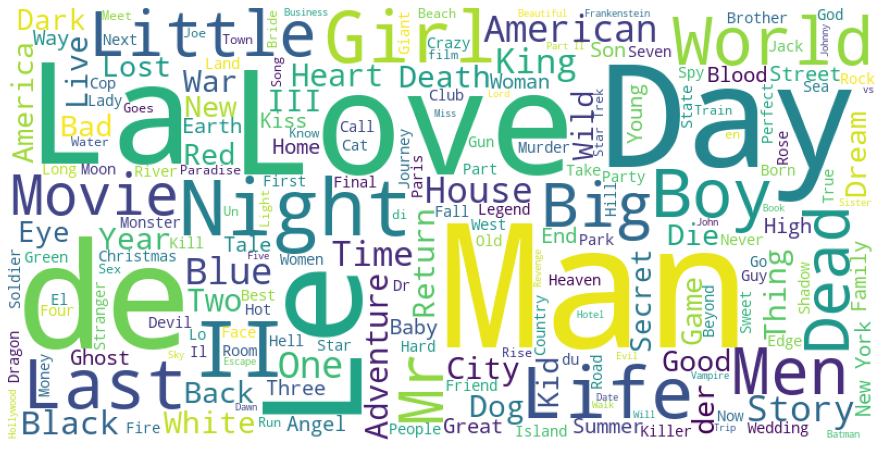

In [6]:
mdf['original_title'] = mdf['original_title'].astype('str')
title_corpus = ' '.join(mdf['original_title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=400, width=800).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [7]:
mdf[['original_title', 'budget', 'year']].sort_values('budget', ascending=False).head()

,original_title,budget,year
7878,Pirates of the Caribbean: On Stranger Tides,380000000,2011
6773,Pirates of the Caribbean: At World's End,300000000,2007
8868,Avengers: Age of Ultron,280000000,2015
6521,Superman Returns,270000000,2006
7744,Tangled,260000000,2010


In [8]:
ldf.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [9]:
ldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9125 non-null   int64  
 1   imdbId   9125 non-null   int64  
 2   tmdbId   9112 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 214.0 KB


In [10]:
rdf.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [11]:
rdf.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


# Building Model

In [12]:
mdf['soup']

0       jealousi toy boy friendship friend rivalri boy...
1       boardgam disappear basedonchildren'sbook newho...
2       fish bestfriend duringcreditssting waltermatth...
3       basedonnovel interracialrelationship singlemot...
4       babi midlifecrisi confid age daughter motherda...
                              ...                        
9214    friendship sidneypoitier wendycrewson jayo.san...
9215    bollywood akshaykumar ileanad'cruz eshagupta t...
9216    bollywood hrithikroshan poojahegde kabirbedi a...
9217    monster godzilla giantmonst destruct kaiju hir...
9218    music documentari paulmccartney ringostarr joh...
Name: soup, Length: 9219, dtype: object

In [13]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(mdf['soup'])

In [14]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [16]:
svd = SVD()
reader = Reader()

In [17]:
data = Dataset.load_from_df(rdf[['userId', 'movieId', 'rating']], reader)
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9017  0.8996  0.8920  0.8837  0.9052  0.8964  0.0077  
MAE (testset)     0.6960  0.6914  0.6849  0.6796  0.6967  0.6897  0.0066  
Fit time          5.48    5.87    6.31    5.44    5.55    5.73    0.33    
Test time         0.21    0.31    0.33    0.51    0.37    0.35    0.10    


{'fit_time': (5.478463172912598,
  5.874985218048096,
  6.3107709884643555,
  5.438047409057617,
  5.554237365722656),
 'test_mae': array([0.69602252, 0.69142642, 0.6848553 , 0.67961611, 0.69667814]),
 'test_rmse': array([0.90166319, 0.89961456, 0.89199802, 0.88370358, 0.90519029]),
 'test_time': (0.2145097255706787,
  0.3068118095397949,
  0.33024001121520996,
  0.5118534564971924,
  0.37433552742004395)}

In [18]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [20]:
rdf[rdf['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [24]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [21]:
df = ldf [['movieId', 'tmdbId']]


In [22]:
df.head()

,movieId,tmdbId
0,1,862.0
1,2,8844.0
2,3,15602.0
3,4,31357.0
4,5,11862.0


In [25]:
df['tmdbId'] = df['tmdbId'].apply(convert_int)
df.columns = ['movieId', 'id']
df = df.merge(mdf[['title', 'id']], on='id').set_index('title')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9219 entries, Toy Story to The Beatles: Eight Days a Week - The Touring Years
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9219 non-null   int64  
 1   id       9219 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 474.1+ KB


In [27]:
indices = pd.Series(mdf.index, index = mdf['title'])
indices_map = df.set_index('id')

In [28]:
indices

title
Toy Story                                                0
Jumanji                                                  1
Grumpier Old Men                                         2
Waiting to Exhale                                        3
Father of the Bride Part II                              4
                                                      ... 
The Last Brickmaker in America                        9214
Rustom                                                9215
Mohenjo Daro                                          9216
Shin Godzilla                                         9217
The Beatles: Eight Days a Week - The Touring Years    9218
Length: 9219, dtype: int64

In [29]:
indices_map.head()

,movieId
id,
862.0,1
8844.0,2
15602.0,3
31357.0,4
11862.0,5


In [30]:
def hybrid(userId, title):
    idm = indices[title]
    tmdbId = df.loc[title]['id']
    movie_id = df.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idm)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = mdf.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [37]:
hybrid(1, 'Grumpier Old Men')

,title,vote_count,vote_average,year,id,est
3687,Shirley Valentine,21.0,6.5,1989,18683,2.893555
2731,Turtle Diary,4.0,8.3,1985,123047,2.880722
6420,Bye Bye Birdie,36.0,5.8,1963,25167,2.816575
3584,The Great Outdoors,155.0,6.4,1988,2617,2.736243
8883,The DUFF,1372.0,6.8,2015,272693,2.725159
4122,Cactus Flower,43.0,7.0,1969,28289,2.708535
1061,Some Kind of Wonderful,104.0,6.9,1987,15143,2.628198
5188,The Whole Ten Yards,282.0,5.5,2004,2122,2.624999
7932,Friends with Benefits,2306.0,6.5,2011,50544,2.606632
409,Getting Even with Dad,43.0,4.5,1994,41579,2.566841
